In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import sklearn.model_selection
import scipy
import sklearn.metrics.pairwise as pw
from time import time
import matplotlib.pyplot as plt

In [2]:
# Specify your directory
DIR = r'C:\Users\Jackie\OneDrive - Georgia Institute of Technology\ISYE6740 Computational Data Analytics\Project\Data\Genres\YoungAdult'

In [3]:
def load_data(file_name):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
    return data

In [4]:
# The Young Adult genre has the highest interaction / book ratio: 34,919,254 interactions and 93,398 books
#interactions = load_data(os.path.join(DIR, 'goodreads_interactions_young_adult.json.gz'))

In [5]:
def load_data(file_name, head = 10000): # should be 1000000
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the "head"th line
            if (head is not None) and (count > head):
                break
    return data

In [6]:
interactions_sample = load_data(os.path.join(DIR, 'goodreads_interactions_young_adult.json.gz'))

In [7]:
print(' == sample record (interaction) ==')
display(np.random.choice(interactions_sample))

 == sample record (interaction) ==


{'user_id': 'ec34d1dce411b82ed55a06f34b35f4a7',
 'book_id': '13487061',
 'review_id': '0898ea1ecc2f7c8d46f5e88babeb9e65',
 'is_read': False,
 'rating': 0,
 'review_text_incomplete': '',
 'date_added': 'Mon Jan 12 14:41:10 -0800 2015',
 'date_updated': 'Mon Jan 12 14:41:11 -0800 2015',
 'read_at': '',
 'started_at': ''}

In [8]:
df = pd.json_normalize(interactions_sample)

In [9]:
# Filter to books that the user has read
is_read = np.logical_and(df['is_read'] == True, df['rating'] != 0) # a book can be read but still have a rating of 0
is_read_df = df[is_read]

In [10]:
is_read_df

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
3,8842281e1d1347389f2ab93d60773d4d,8684868,d29b8238762d70b7c2b67941bc81fbe0,True,3,,Tue Dec 17 13:42:25 -0800 2013,Tue Dec 17 13:47:26 -0800 2013,Sun Dec 15 00:00:00 -0800 2013,Sat Dec 14 00:00:00 -0800 2013
4,8842281e1d1347389f2ab93d60773d4d,8423493,357c8c178fd0e06cff5c025649231672,True,2,,Sun Dec 08 01:26:12 -0800 2013,Tue Dec 27 05:37:48 -0800 2016,Tue Dec 10 00:00:00 -0800 2013,
5,8842281e1d1347389f2ab93d60773d4d,87976,e6306259819c47f278e78d32a1b73ddf,True,5,,Wed Oct 17 17:49:11 -0700 2012,Wed Oct 17 17:49:11 -0700 2012,,
6,8842281e1d1347389f2ab93d60773d4d,18116,8aa100c7b681e9fedbe2c6bd2c25696a,True,5,,Fri Apr 29 13:14:05 -0700 2011,Fri Apr 29 13:14:05 -0700 2011,,
7,8842281e1d1347389f2ab93d60773d4d,2767052,248c011811e945eca861b5c31a549291,True,5,I cracked and finally picked this up. Very enj...,Wed Jan 13 13:38:25 -0800 2010,Wed Mar 22 11:46:36 -0700 2017,Sun Mar 25 00:00:00 -0700 2012,Fri Mar 23 00:00:00 -0700 2012
...,...,...,...,...,...,...,...,...,...,...
9996,4a44f603cc3df339acc48590044a2db0,17261628,2310bbf77a0d72234e4739a3adf7194d,True,3,,Sat Jan 24 21:56:03 -0800 2015,Sat Dec 19 17:16:14 -0800 2015,Sun Jan 25 17:01:54 -0800 2015,Sat Jan 24 21:56:03 -0800 2015
9997,4a44f603cc3df339acc48590044a2db0,18190208,c1c267254139f66d2b7d26d27a423c1d,True,4,See full review for The Witch Hunter at: <a ta...,Thu Jan 15 09:52:14 -0800 2015,Sat Jul 18 09:16:21 -0700 2015,Fri Jul 10 00:00:00 -0700 2015,Fri Jul 10 00:00:00 -0700 2015
9998,4a44f603cc3df339acc48590044a2db0,22308716,0c71f23060e6513f28cad1496b6a7e61,True,5,"See full review for Red Queen at: <a target=""_...",Thu Jan 15 09:51:38 -0800 2015,Sat Dec 19 17:20:26 -0800 2015,Tue Mar 03 00:00:00 -0800 2015,Thu Feb 26 00:00:00 -0800 2015
9999,4a44f603cc3df339acc48590044a2db0,18967205,911a06b2f968713818e78544434a330e,True,4,"See full review for Hellhole at: <a target=""_b...",Thu Jan 15 09:50:59 -0800 2015,Sat Feb 28 15:58:19 -0800 2015,Fri Feb 27 00:00:00 -0800 2015,Fri Feb 27 00:00:00 -0800 2015


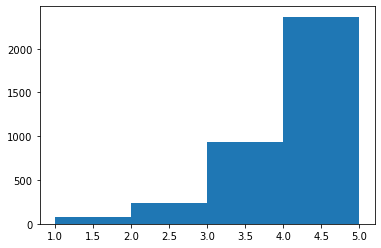

In [11]:
plt.hist(is_read_df['rating'], bins=[1,2,3,4,5])
plt.show()

In [12]:
# Calculate average rating
avg_rating = np.mean(is_read_df['rating'])
avg_rating

3.8719512195121952

In [13]:
# Define user-book rating matrix
mat = pd.pivot(is_read_df, index='user_id', columns='book_id', values='rating')
mat.replace(0, np.nan, inplace=True)

In [14]:
mat

book_id,10001793,10004138,10025007,10025305,1003318,1008231,10118172,10151730,10165727,10165761,...,9917938,9917945,9918053,9918133,9939115,9947386,99561,9961796,9972882,9975679
user_id,,,,,,,,,,,,,,,,,,,,,
012515e5802b2e0f42915118c90fa04b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
012aa353140af13109d00ca36cdc0637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01d02898170634e6e7232650ebbf2e43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01ec1a320ffded6b2dd47833f2c8e4fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
040b31603912dc03f19e0b76d58c3660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f4d16ea4ac59af59d257631398af39f4,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
f88032f4ad97b46654fe59ce3387cf5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f8a89075dc6de14857561522e729f82c,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


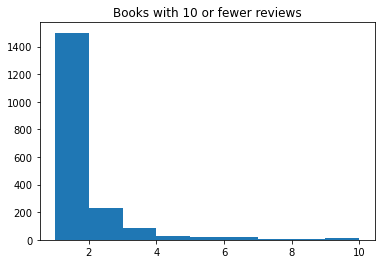

In [50]:
plt.hist(mat.count(), bins=[1,2,3,4,5,6,7,8,9,10])
plt.title("Books with 10 or fewer reviews")
plt.show()

In [49]:
np.max(mat.count())

66

In [37]:
# Exclude books with only 1 review from test set
mat.count()==1

book_id
10001793     True
10004138     True
10025007    False
10025305    False
1003318      True
            ...  
9947386      True
99561       False
9961796     False
9972882      True
9975679      True
Length: 2102, dtype: bool

In [38]:
is_read_df['book_id']

3         8684868
4         8423493
5           87976
6           18116
7         2767052
           ...   
9996     17261628
9997     18190208
9998     22308716
9999     18967205
10000    20958632
Name: book_id, Length: 3608, dtype: object

In [52]:
(mat.count()==1).sum()

1501

In [20]:
# Train/test split
train, test = sklearn.model_selection.train_test_split(is_read_df, test_size=0.1, random_state=1111)
train.shape, test.shape

((3247, 10), (361, 10))

In [40]:
# Set all test values to nan
mat_trainonly = mat
zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_mask = np.full(mat.shape, False)
for i in range(len(zipped_test)):
    row_idx = mat_trainonly.index.get_loc(zipped_test[i][0])
    col_idx = mat_trainonly.columns.get_loc(zipped_test[i][1])
    test_mask[row_idx, col_idx] = True
test_actuals = np.array(mat)[test_mask] # Save test actuals
mat_trainonly[test_mask] = np.nan

In [41]:
mat_trainonly.at[zipped_test[0][0], zipped_test[0][1]]

nan

In [42]:
# Calculate sparsity of data
not_null = mat_trainonly.count().sum()
sparsity = 1 - not_null / (mat.shape[0] * mat_trainonly.shape[1])
sparsity

0.9875425861698536

In [43]:
mat_trainonly.count().sort_values(ascending=False)

book_id
2767052     66
7260188     47
6148028     44
41865       38
11870085    35
            ..
353900       0
354520       0
35504431     0
35712937     0
15817997     0
Length: 2102, dtype: int64

In [ ]:
# Number of books with 0 ratings outside of what was in the test set
(mat_trainonly.count()==0).sum()

In [ ]:
# Calculate average rating for each book over users
avg_book_rating = np.nanmean(mat_trainonly, axis=0) # column avg r_j
# For empty columns, fill with avg rating
np.nan_to_num(avg_book_rating, copy=False, nan=avg_rating)

# Fill missing value with the appropriate average for that book
filled = np.where(np.isnan(mat_trainonly), avg_book_rating, mat_trainonly)

In [ ]:
# Remove from each user (row) the mean over all books
avg_user_rating = np.average(filled, axis=1) # row avg r_i
avg_user_rating_col_vec = avg_user_rating.reshape(len(avg_user_rating),1)
normalized = filled - avg_user_rating_col_vec

In [ ]:
normalized

In [ ]:
normalized.shape

In [ ]:
# Perform SVD, decide on a rank k, and calculate a reduced rating matrix to remove noise
# Can use sparse matrix algorithms because of special structure
# How to choose k: if top few values are big and the rest are small, take the big values. So chose k=11
U, S, VT = scipy.sparse.linalg.svds(normalized, k=6) # CHANGE BACK TO k=11

In [ ]:
#U, S, VT = np.linalg.svd(normalized) #k=10

# U = U[:, :9]
# S = S[:9]
# VT = VT[:9, :]

In [ ]:
S

In [ ]:
U.shape, S.shape, VT.shape

In [ ]:
reduced_rating = U @ np.diag(S) @ VT

In [ ]:
reduced_rating # SHOULD THIS BE >=1? Maybe not, because it's already been reduced

In [ ]:
reduced_rating.shape

In [ ]:
# Calculate matrix product for dimensionality-reduced rating matrix
sqrtS = np.diag(np.sqrt(S))
meta_on_users = U @ np.transpose(sqrtS)
meta_on_items = sqrtS @ VT

In [ ]:
meta_on_items

In [ ]:
# # Calculate similarity of 2 books j and f based on the reduced rating matrix
# # Similarity is the correlation of 2 movies based on average over users
# def similarity(j, f, matrix):
#     j_col = matrix[:, j]
#     f_col = matrix[:, f]
#     numerator = np.sum(np.multiply(j_col, f_col))
#     denominator = np.sqrt(np.multiply(np.sum(np.square(j_col)), np.sum(np.square(f_col))))
#     return numerator / denominator

In [ ]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(num_books):
#         similarities[i, j] = similarity(i, j, meta_on_items)
# t2 = time()

In [ ]:
# t2-t1

In [ ]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# col_prods = meta_on_items.T.dot(meta_on_items)

# similarities2 = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(i, num_books):
#         similarities2[i, j] = col_prods[i, j] / np.sqrt(col_prods[i, i] * col_prods[j, j])
#         similarities2[j, i] = similarities2[i, j]
# t2 = time()

In [ ]:
# similarities.shape, t2-t1, np.allclose(similarities, similarities2)

In [ ]:
num_books = reduced_rating.shape[1]
t1 = time()
similarities = pw.cosine_similarity(meta_on_items.T, meta_on_items.T)
t2 = time()

In [ ]:
similarities.shape, t2-t1

In [ ]:
# # Without reducing dimensionality
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = pw.cosine_similarity(reduced_rating.T, reduced_rating.T)
# t2 = time()
# similarities.shape, t2-t1

In [ ]:
# # TODO: try optimizing
# # Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
# num_users = reduced_rating.shape[0]
# predictions = np.zeros((num_users, num_books))

# # Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
# most_similar_idx = np.argsort(similarities, axis=1)[:,-10:]
# for a in range(num_users):
#     for j in range(num_books):
#         numerator = 0
#         denominator = 0
#         # check that similarities are non-negative
#         for k in most_similar_idx[j,:]:
#             sim = similarities[j,k]
#             if sim < 0:
#                 break
#             numerator += sim * (reduced_rating[a,k] + avg_user_rating[a])
#             denominator += sim
#         predictions[a,j] = numerator/denominator

In [ ]:
def rearrange_cols(arr, idx):
    rows = np.indices(idx.shape)[0]
    return arr[rows, idx]

# Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
num_users = reduced_rating.shape[0]
predictions = np.zeros((num_users, num_books))

# Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
t1 = time()
most_similar_idx = np.argsort(similarities, axis=1)[:,:-11:-1]
adjusted_rating = reduced_rating + avg_user_rating[:,np.newaxis]
nonneg_sims = np.where(similarities > 0, similarities, 0)
sorted_sims = rearrange_cols(nonneg_sims, most_similar_idx)
denominator = np.sum(sorted_sims, axis=1)
for a in range(num_users):
    for j in range(num_books):
        numerator = 0
        for k in most_similar_idx[j,:]:
            numerator += nonneg_sims[j,k] * adjusted_rating[a,k]
        predictions[a,j] = numerator/denominator[j]
t2 = time()
t2-t1

In [ ]:
print(np.min(predictions), np.max(predictions))
predictions

In [ ]:
np.shape(predictions)

In [ ]:
# Define error function
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

In [ ]:
# Calculate training error
training_mask = np.array(mat_trainonly.notna())
train_predictions = predictions[training_mask]
train_actuals = np.array(mat_trainonly)[training_mask]
train_rmse = rmse(train_predictions, train_actuals)
train_rmse

In [ ]:
train_predictions, train_actuals

In [ ]:
# Calculate test error
#zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_predictions = predictions[test_mask]
test_rmse = rmse(test_predictions, test_actuals)
test_rmse

In [ ]:
test_predictions[:10], test_actuals[:10]

In [ ]:
# Calculate error if just rated everything the avg rating
avg_train = np.full(train_actuals.shape, avg_rating)
avg_train_rmse = rmse(avg_train, train_actuals)
avg_test = np.full(test_actuals.shape, avg_rating)
avg_test_rmse = rmse(avg_test, test_actuals)
avg_train_rmse, avg_test_rmse

# Debugging

In [ ]:
np.argsort(similarities, axis=0)

In [ ]:
testing = np.array([[1,5,8,3,7],[1,2,3,4,5]])
sorted_testing = np.argsort(testing, axis=1)
sorted_testing[:,-2:]

In [ ]:
np.all(predictions < 5), np.all(predictions > 1)

In [ ]:
np.all(reduced_rating < 5), np.all(reduced_rating > 1)

In [ ]:
reduced_rating

In [ ]:
avg_user_rating